# Final Project Report

#### by Hanyuan Hu

## 1. Introduction

In this project, I use a two factor Vasciek model for OIS rate and then use the model to price LIBOR swaptions and LIBOR interest rate caps/floors numerically by doing Monte Carlo simulation using CPU multi-threading and CUDA respectively. In the following sessions, I will first start with model definition and then derive some useful analytical formula to speed up the process. The next step I detail specific steps for swaption and cap/floor pricing. I also provide their corresponding **functions** and where to find them in *source files*. I also adopted the rate model to a dll library and use SciPy.optimize package to fit the model to real OIS data. At the end of this research, I provide a profiling result of function calls to conclude which parts are bottle necks of the implementation. 

## 2. Model Definition

I choose to model the OIS rate, which is considered to be the risk-free rate. I assume LIBOR yield curve is the OIS yield curve of corresponding maturity plus porportionate and bounded random term:

$$y^{LIBOR}(t) = y^{OIS}(t) ( 1 + u + we_t)$$

where $e_t$ I assume to be a uniformlly distributed random variable between 0 and 1 and I also set constant $u$ and $w$ so that the LIBOR must be larger than OIS yield. 

I use a cananical form of the two-factor Vasciek model for OIS rate: 
$$\begin{aligned} dY_1(t) &= - \lambda_{1} Y_1(t) dt + dW_1(t) \\ dY_2(t) &= -\lambda_{21} Y_1(t) dt - \lambda_{2} Y_2(t) dt + dW_2(t) \\ r(t) &= \delta_0 + \delta_1 Y_1(t) + \delta_2 Y_2(t)\end{aligned}$$


Notice that the diffusion term is represented by $\delta_1$ and $\delta_2$. Constant drift term is represented in $\delta_0$. 

We first solve some explicit solutions related to the problem to accelerate simulation process.

Since this is an affine model, we have zero-coupon bond price in the form of 
$$P(t, y1, y2) = E_t[e^{- \int_t^T r_s ds}] = e^{-y_1 C_1(T - t) - y_2 C_2(T - t) - A(T - t)}$$

I use Freyman-Kac Theorem to transform this pricing formula first into a PDE and simplify to 3 ODEs. Solve them and get:

$$\begin{aligned} C_2(t, T) &= \frac{\delta_2}{\lambda_2} (1 - e^{-\lambda_2 (T - t)}) \\ C_1(t, T) &= \frac{1}{\lambda_1}(\delta_1 - \frac{\lambda_{21} \delta_2}{\lambda_2})(1 - e^{-\lambda_1 (T-t)}) + \frac{\lambda_{21} \delta_2}{\lambda_2 (\lambda_1 - \lambda_2)}(e^{-\lambda_2(T - t)} - e^{-\lambda_1 (T - t)}) \quad if \ \lambda_1 \neq \lambda_2 \\ or \ &= \frac{1}{\lambda_1} (\delta_1 - \frac{\lambda_{21} \delta_2}{\lambda_1}) (1 - e^{-\lambda_1 (T - t)}) + \frac{\lambda_{21} \delta_2}{\lambda_1}(T -t) e^{-\lambda_1 (T - t)} \quad if \ \lambda_1 = \lambda_2 \\ A(t, T) &= \int_t^T -\frac{1}{2} C_1^2(u) -\frac{1}{2} C_2^2(u) + \delta_0 du \end{aligned}$$

For the A term, the analytical solution is quite lengthy. I use a simple numerical integration to get the value.

For this Gaussian model, we can also solve for future distribution of state vector in closed form

$$\begin{aligned} Y_1(t) &= e^{-\lambda_1 t} Y_1(0) + \int_0^t e^{-\lambda_1 (t - u)} dW_1(u) \\ Y_2(t) &= \frac{\lambda_{21}}{\lambda_1 - \lambda_2} (e^{-\lambda_1 t} - e^{-\lambda_2 t}) Y_1(0) + e^{-\lambda_2 t} Y_2(0) + \frac{\lambda_{21}}{\lambda_1 - \lambda_2} \int_0^t (e^{-\lambda_1(t-u)} - e^{-\lambda_2 (t - u)}) dW_1(u) + \int_0^t e^{-\lambda_2 (t - u)} dW_2(u) \quad if \ \lambda_1 \neq \lambda_2 \\ or \ &= -\lambda_{21} t e^{-\lambda_1 t }Y_1(0) + e^{-\lambda_1 t} Y_2(0) -\lambda_{21} \int_0^t (t - u) e^{-\lambda_1 (t - u)} dW_1(u) + \int_0^t e^{-\lambda_1(t - u)}dW_2(u) \quad if \ \lambda_1 = \lambda_2 \end{aligned}$$

So we conclude $Y_1(t)$ and $Y_2(t)$ are normally distributed. The mean term is easily read from above representation. I derive the variance term in closed form:

$$\begin{aligned} Var[Y_1(t)] &= \frac{1}{2\lambda_1} (1 - e^{-2\lambda_1 t}) \\ Var[Y_2(t)] &= \frac{\lambda_{21}^2}{(\lambda_1 - \lambda_2)^2} \left[\frac{1}{2 \lambda_1} ( 1 - e^{-2\lambda_1 t}) + \frac{1}{2\lambda_2}(1 - e^{-2\lambda_2 t}) - \frac{2}{\lambda_1 + \lambda_2} (1 - e^{-(\lambda_1 + \lambda_2) t} \right] + \frac{1}{2 \lambda_2} (1 - e^{-2\lambda_2 t}) \quad if \ \lambda_1 \neq \lambda_2 \\ or \  &= \frac{\lambda_{21}^2}{2 \lambda_1} \left[ -t^2 e^{-2\lambda_1 t} + \frac{1}{\lambda_1}(1 - e^{-2 \lambda_1 t })\right] + \frac{1}{2\lambda_1}(1 - e^{-2\lambda_1 t}) \quad if \  \lambda_1 = \lambda_2 \end{aligned}$$

I coded up these terms in the program. The rate model terms can be find at *cpu_rate_model.h* or *cuda_rate_model.h*.

```c++
// cpu_rate_model.h
namespace OIS_model
{
    inline void set_params(double lambda_1, double lambda_21, double lambda_2, double delta_0, double delta_1, double delta_2)
    
    inline double _C1_(double tao)

    inline double _C2_(double tao)

    inline double _A_(double tao, unsigned int N = integrate_N)

    inline double P(double y1_0, double y2_0, double tao)

    inline double y(double y1_0, double y2_0, double tao)
}


namespace LIBOR_model
{
    inline double y(double y1_0, double y2_0, double tao, double* seeds)
}
```

```c++
// cuda_rate_model.h


namespace OIS_model
{
    constexpr double d_lambda_1 = LAMBDA_1;
    constexpr double d_lambda_21 = LAMBDA_21;
    constexpr double d_lambda_2 = LAMBDA_2;

    constexpr double d_delta_0 = DELTA_0;
    constexpr double d_delta_1 = DELTA_1;
    constexpr double d_delta_2 = DELTA_2;


    __device__ double _cuda_C1_(double tao)

    
    __device__ double _cuda_C2_(double tao)


    __device__ double _cuda_A_(double tao, unsigned int N = OIS_model::integrate_N)


    __device__ double cuda_P(double y1_0, double y2_0, double tao)


    __device__ double cuda_y(double y1_0, double y2_0, double tao)
}


namespace LIBOR_model
{
    __device__ double cuda_y(double y1_0, double y2_0, double tao, double* seeds)

}
```

## 3. Swaption Pricing

### 3. 1 Pricing Formulas

European swaption gives its holder the right to enter one pre-determined swap in future. In this session, we focus on deriving formulas for call option, while for put option, we only have to plug in put-styple payoff function. Suppose the expiration of this option is at $T_0$, and require counterparties to exchange cash flow m times for n years, then pay-off of this swaption is: $$payoff(T_i) = \frac{L}{m} max(s_{T_0} - s_K, 0)$$ that happens at times $T_1, T_2, \cdots , T_{mn}$ 

Then we have to find the distribution of swap rate at time $T_0$. Let $f(t_1, t_2)$ be the forward rate between $t_1$ and $t_2$, then

$$\sum_{i=1}^{mn} P(T_0, T_i) f(T_{i-1}, T_i) = \sum_{i=1}^{mn} P(T_0, T_i) S_{T_0} \qquad (1) $$

$$f(T_{i-1}, T_i) = \frac{1}{T_{i} - T_{i-1}} \left[ \frac{P^{LIBOR}(T_0, T_{i-1})}{P^{LIBOR}(T_0, T_i)} - 1 \right] = \frac{1}{T_{i} - T_{i-1}} \left(e^{y^{LIBOR}_i T_i - y^{LIBOR}_{i - 1} T_{i - 1}} -1\right)$$

Mathematically, if we have a sample of state vectors $Y_{T_0}$, we can first calculate the corresponding swap rate to get a sample of the rate and finally calculate option value using this sample.

### 3. 2 Implementation 

I mainly focus on CPU version implementation. The CUDA version are very much the same, except several functions I cannot use so that I provide a device compatible version. Any function used by CPU can be find in *cpu_\** files, while you can easily find the CUDA version in *cuda_\**. 

First, I borrow the $U(0, 1)$ random number generator, seed skiping function and normal random variable generator using inverse transformation developed in previous problem set. 

```c++
// cpu_rand.h

inline double rand01(double *dseed)
    
inline void rand01_skip_ahead(unsigned int times, double *seed_ar)

inline double randn(double *seed)
```

In *derivatives.h*, I provide an interface of the pricing function.

```c++
// cpu_derivatives.h
double swaption(double y1_0, double y2_0, double tao, OptionType op_type, double K,
    unsigned int t_count, double tenor, double F, unsigned int sim_count, unsigned int step_count);
```

*derivatives.cpp* is the file I implemented detailed simulation steps. First, I use function **\_one_sim** to generate discounting processes $D_t$ by  numerically integrating $r_t$ from $0$ to $T_0$. I also keep the last state vectors for pricing the swap at $T_0$.

The next function **\_swaption_pay_off** is coded to first calculate swap rate as in Eq.(1), then plug the swap rate into option payoff function and finally discount the payoff by using $D_t$ generated by **\_one_sim**.

In **derivatives::swaption**, I repeated the process above multiple times and calculate the mean as the price. I use a util function created myself ** multi_map** to allow for simular interface and function design for both CPU and CUDA version. 

```c++
// cpu_derivatives.cpp

void _one_sim(double* disc_loc, size_t job_id, double* y1_t_loc, double* y2_t_loc, double y1_0, double y2_0, double tao,
    unsigned int sim_count, unsigned int step_count, double* seeds)
    
void _swaption_pay_off(double *sw_p_loc, size_t job_id, unsigned int sim_count, double* y1_t_loc, double* y2_t_loc, 
    double tenor, derivatives::OptionType op_type, double K, unsigned int t_count, double F, double* seeds)
    
double derivatives::swaption(double y1_0, double y2_0, double tao, derivatives::OptionType op_type, double K, 
    unsigned int t_count, double tenor, double F, unsigned int sim_count, unsigned int step_count)
```

```c++
// multi_thread_map.h

template <typename ReturnType, typename... Args>
void multi_map(unsigned int pool_size, size_t n_jobs, void(*func)(ReturnType*, size_t, Args...), ReturnType* result_loc, Args... args)
```

To justify this design, I provide a multi-threading function call using CPU and a global function call using CUDA as comparison:

```c++
multi_map(CPU_THREAD_COUNT, sim_count, _dsc_op_pay_off, dsc_op_loc, sim_count, y1_0, y2_0, op_type, K, F, t_count, tenor, seeds); // cpu

_dsc_op_pay_off <<< block_count, CUDA_THREAD_COUNT >>> (d_dsc_op_loc, sim_count, y1_0, y2_0, op_type, K, F, t_count, tenor, d_seeds); //cuda
cudaDeviceSynchronize();
```

## 4. Interest Rate Cap/Floor Pricing

### 4. 1 Pricing Formulas

Interest rate caps and floors are options on floating rate notes. For a cap on floating rate note with maturity of $T$, principal $L$, cap rate $f^{LIBOR}_K$ and a serial of reset dates $t_1, t_2, \cdots, t_n$, the payoff of this optionality is $$L \delta_i max(f^{LIBOR}_i - f^{LIBOR}_K)$$ $f^{LIBOR}_i$ is the future spot LIBOR rate from $t_i$ to $t_{i+1}$. We assume $\delta_i$ to be constant.

We have to simulate the dynamic of $Y_i$ and use zero-bond pricing formula to derive $f^{OIS}_i$, which is the yield, and finally use the relationship between OIS and LIBOR to derive $f^{LIBOR}_i$. The the option value is the discounted payoff.

### 4. 2 Implementation

I use the same short rate model and its utility functions as above. The I first implemented **\_dsc_op_pay_off**, which simulate state vector at $t_i$ and calculate the discounted payoff.

In **derivatives::cpu_cap_floor** I repeated this procedure for several times on multiple threads, and finally take the average as theoratical price. 

```c++
// cpu_derivatives.h

void _dsc_op_pay_off(double* dsc_op_loc, size_t job_id, unsigned int sim_count, double y1_0, double y2_0,
    derivatives::OptionType op_type, double K, double F, unsigned int t_count, double tenor, double* seeds)

double derivatives::cpu_cap_floor(double y1_0, double y2_0, derivatives::OptionType op_type, double K,
    unsigned int t_count, double tenor, double F, unsigned int sim_count)
    
```

## 5. Model Calibration Using SciPy.optimize

In this session, I first modified the *cpu_rate_model.h* to be a dll. Then load this dll to Python using ctypes. Finally, I formulate the optimization problem in a non-linear least square one and fit this model to 5 days' OIS curve data by using SciPy.optimize.

In [1]:
import ctypes as ct
import numpy as np
import pandas as pd
from scipy.optimize import least_squares 

In [2]:
dll = ct.windll.LoadLibrary("./rate_dll2/x64/Release/rate_dll2.dll")    
y_func = dll.y
y_func.argtypes = [ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double]
y_func.restype = ct.c_double

In [3]:
def y(y1, y2, tao, lambda_1, lambda_21, lambda_2, delta_0, delta_1, delta_2):
    return y_func(y1, y2, tao, lambda_1, lambda_21, lambda_2, delta_0, delta_1, delta_2)

vec_y = np.vectorize(y, otypes=[float], cache=True)

In [4]:
start_date = pd.datetime(2013, 4, 28)
end_date = pd.datetime(2013, 5, 3)

In [5]:
result_df = pd.read_excel("OIS_data.xlsx", index_col=0, parse_dates=True)
result_df = result_df[(result_df.index >= start_date) & (result_df.index <= end_date)]

In [6]:
result_df

,VALUE_x,VALUE_y,VALUE_x.1,VALUE_y.1,VALUE_x.2,VALUE_y.2,VALUE_x.3,VALUE_y.3,VALUE_x.4,VALUE_y.4,VALUE_x.5,VALUE_y.5,VALUE_x.6,VALUE_y.6
DATE,,,,,,,,,,,,,,
2013-04-29,0.16820,0.17940,0.19820,0.23930,0.27410,0.32010,0.37690,0.42990,0.48420,0.52890,0.56620,0.60830,0.65710,0.70850
2013-04-30,0.16670,0.17840,0.19820,0.23780,0.27310,0.31760,0.37240,0.42540,0.48020,0.52440,0.56170,0.60480,0.65360,0.70450
2013-05-01,0.16670,0.17840,0.19820,0.23790,0.27310,0.31760,0.37240,0.42540,0.47970,0.52390,0.56120,0.60430,0.65310,0.70400
2013-05-02,0.16770,0.17940,0.19820,0.23740,0.27310,0.31760,0.37240,0.42540,0.47970,0.52390,0.56120,0.60430,0.65310,0.70310
2013-05-03,0.16720,0.17890,0.19820,0.23740,0.27510,0.31860,0.37240,0.42540,0.47920,0.52265,0.55905,0.60265,0.65195,0.70210


In [7]:
data_mat = result_df.values.astype(np.float64)

In [8]:
tao_ar = np.array([1/12/4, 2/12/4, 1/12, 2/12, 3/12, 4/12, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 12/12])

def target(x0, tao_ar=tao_ar, target_dt=data_mat):
    return np.ravel(vec_y(x0[0], x0[1], tao_ar, x0[2], x0[3], x0[4], x0[5], x0[6], x0[7]) - target_dt)

In [9]:
rst = least_squares(target, x0=np.random.rand(8,), method="lm")

In [10]:
rst.success

True

In [11]:
rst.x

array([ 4.23980854,  5.15667608, -0.55189439,  1.09911927, -0.55268246,
        0.70157289,  0.19325199, -0.2645972 ])

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 20, 10

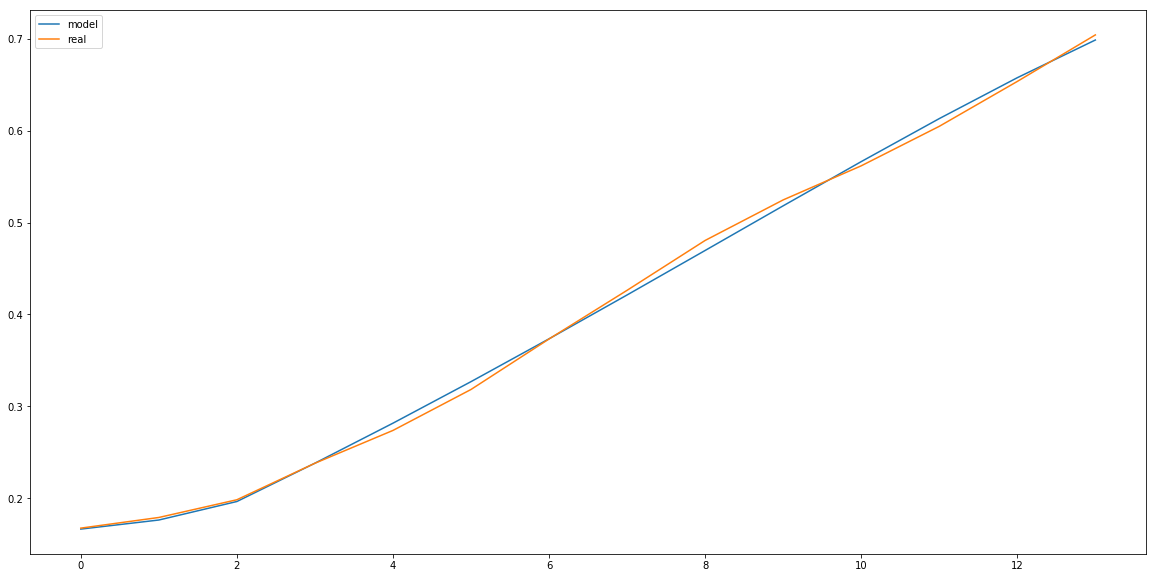

In [13]:
fig, ax = plt.subplots()
plt.plot(vec_y(rst.x[0], rst.x[1], tao_ar, rst.x[2], rst.x[3], rst.x[4], rst.x[5], rst.x[6], rst.x[7]), label="model");
plt.plot(np.mean(data_mat, axis=0), label="real")
ax.legend();

This model fit the simple average of 5 days' yield curve quite well. However, I understand this model cannot capture volatility feature of the curve perfectly, and one remedy to which will require stochastic vol term in short rate model. This part is beyond scope of this research.

## 6. Performance Analysis

### 6. 1 Execution Results

![Execution Results](./final_project2/result.PNG)

As shown above, both versions of models have the same output.

### 6. 2 Function Analysis

I find it instructive to use Visual Studio's profiler to get an idea about which functions are heavily used and of whom are bottle necks. In the report, Inclusive Samples indicate how much work was done by the function and any functions called by it. High inclusive counts point to the functions that are most expensive overall. Exclusive Samples indicate how much work was done by the code in the function body, excluding the work done by functions that were called by it. High exclusive counts may indicate a performance bottleneck within the function itself.

In [14]:
CPU_funcs = pd.read_csv("./CPU_report_FunctionSummary.csv")
CPU_funcs = CPU_funcs[CPU_funcs["Function Name"].apply(lambda x: "[" not in x)]
del CPU_funcs["Unnamed: 5"]
CPU_funcs.sort_values("Inclusive Samples %", ascending=False)

,Function Name,Inclusive Samples,Exclusive Samples,Inclusive Samples %,Exclusive Samples %
32,Concurrency::details::_DefaultPPLTaskScheduler...,"18,010",0,97.56,0.00
42,Concurrency::details::_TaskProcHandle::_RunCho...,"18,006",0,97.54,0.00
60,std::_Packaged_state<void __cdecl(void)>::_Cal...,"17,995",0,97.48,0.00
54,std::_Func_impl_no_alloc<<lambda_052e919cc0e53...,"17,995",0,97.48,0.00
0,OIS_model::_A_,"17,745","17,733",96.12,96.06
36,Concurrency::details::_PPLTaskHandle<unsigned ...,"10,548",0,57.14,0.00
56,std::_Func_impl_no_alloc<std::_Fake_no_copy_ca...,"10,539",0,57.09,0.00
11,_swaption_pay_off,"10,539",2,57.09,0.01
5,LIBOR_model::y,"10,527",11,57.02,0.06
34,Concurrency::details::_PPLTaskHandle<unsigned ...,"7,279",0,39.43,0.00


For the CPU version, apparently the numerical integration step in **OIS_model::\_A\_** is the most expensive. We also find the mapping function using multi-threading pool **multi\_map** is quite efficient.

In [15]:
GPU_funcs = pd.read_csv("./GPU_report_FunctionSummary.csv")
GPU_funcs = GPU_funcs[GPU_funcs["Function Name"].apply(lambda x: "[" not in x)]
del GPU_funcs["Unnamed: 5"]
GPU_funcs.sort_values("Inclusive Samples %", ascending=False)

,Function Name,Inclusive Samples,Exclusive Samples,Inclusive Samples %,Exclusive Samples %
189,main,"10,526",0,79.74,0.00
157,__scrt_common_main_seh,"10,527",0,79.74,0.00
175,cudart::cudaApiDeviceSynchronize,"9,944",0,75.33,0.00
164,cudaDeviceSynchronize,"9,944",0,75.33,0.00
188,derivatives::cuda_swaption,"8,853",0,67.06,0.00
187,derivatives::cuda_cap_floor,"1,673",0,12.67,0.00
91,cudaMemcpy,441,1,3.34,0.01
178,cudart::cudaApiMemcpy,440,0,3.33,0.00
93,cudart::driverHelper::memcpyDispatch,439,1,3.33,0.01
177,cudart::cudaApiMalloc,75,0,0.57,0.00


In the CUDA version, we can observe most of the runnining time was spent on GPU calculations, indicated by **cudaDeviceSynchronize**. Another difference from the CPU version is that **cudaMemcpy** is much more expensive than **Memcpy**.

## 7. Conclusions

I implemented European swaption and interest rate cap/floor pricing tools using a 2-factor Vasicek model and carried out model calibration. We get the same result from both versions.

Some remarks on transforming CPU models to CUDA ones. I intentionally deveop a **set_params** function in *cpu_rate_model.h* to allow users to call this function to modify static model parameters for optimization. However, it turns out static variables are not able to access from device, and I failed to find any easy way to pass these variable to the device memory and use identifiers of the variables in global or device functions. So I turned them into **constexpr**, which are just like constants defined by macros so that they are determined after compilation. It natually follows that we cannot optimize parameters on with CUDA models. I suggest first using CPU version to calibrate parameters with data of relatively simpler products and then applying those tuned params to CUDA model to price more complex products. 

## Reference

* Shreve, S. E., (2004). Stochastic Calculus for Finance II: Continuous-Time Models 
* Hull, J. C., (2014). Options, Futures and Other Derivatives